In [60]:

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

from IPython.display import Markdown


import requests
import cv2
from matplotlib import pyplot as plt 
import numpy as np


import os
from PIL import Image


In [61]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [62]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class GoProDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Transform to be applied on the input images.
            target_transform (callable, optional): Transform to be applied on the target images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.samples = []

        # Iterate over each sequence folder
        for sequence in os.listdir(root_dir):
            sequence_dir = os.path.join(root_dir, sequence)
            blur_dir = os.path.join(sequence_dir, 'blur')
            sharp_dir = os.path.join(sequence_dir, 'sharp')

            # List and sort blur and sharp images to ensure they are aligned
            blur_images = sorted([os.path.join(blur_dir, f) for f in os.listdir(blur_dir) if f.endswith('.png')])
            sharp_images = sorted([os.path.join(sharp_dir, f) for f in os.listdir(sharp_dir) if f.endswith('.png')])

            # Pair each blur image with its corresponding sharp image
            self.samples.extend(zip(blur_images, sharp_images))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        blur_path, sharp_path = self.samples[idx]
        blur_image = Image.open(blur_path)
        sharp_image = Image.open(sharp_path)

        if self.transform:
            blur_image = self.transform(blur_image)
        if self.target_transform:
            sharp_image = self.target_transform(sharp_image)

        return blur_image, sharp_image



In [63]:
from torch.utils.data import random_split
# Define transformations if needed
transform = transforms.Compose([
    transforms.CenterCrop((540,960)),
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    transforms.CenterCrop((540,960)),
    transforms.ToTensor(),
])

# Create dataset
train_dataset = GoProDataset(root_dir='GoPro/train', transform=transform, target_transform=target_transform)
test_dataset = GoProDataset(root_dir='GoPro/train', transform=transform, target_transform=target_transform)

# Define the size of the validation set
val_size = int(0.2 * len(train_dataset))  # 20% of the training dataset for validation

# Split train_dataset into train and validation sets
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


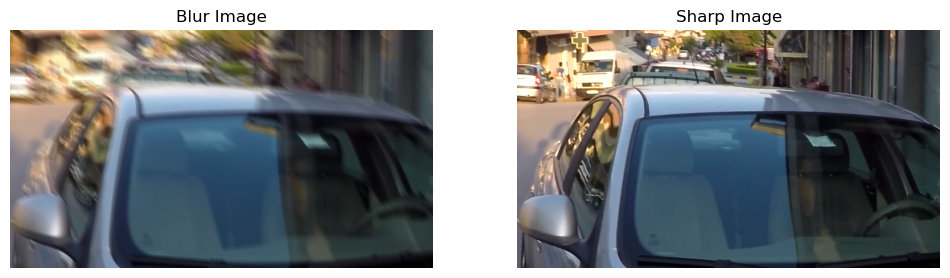

In [64]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')

# Iterate over data and display images
for blur_images, sharp_images in train_loader:
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    imshow(blur_images[0])
    plt.title('Blur Image')
    
    plt.subplot(122)
    imshow(sharp_images[0])
    plt.title('Sharp Image')
    plt.show()

    # Optionally, break after the first pair is shown
    break

# **Model**

In [67]:

"""
Experiment options:
- Clip input range?!
- Sequential or parallel attention, which order?
- Spatial attention options (see CBAM paper)
- Which down and up sampling method? Pool, Conv, Shuffle, Interpolation
- Add vs. concat skips
- Add FMEN-like Unshuffle/Shuffle
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List


class AttentionBlock(nn.Module):
    def __init__(self, dim: int):
        super(AttentionBlock, self).__init__()
        self._spatial_attention_conv = nn.Conv2d(2, dim, kernel_size=3, padding=1)

        # Channel attention MLP
        self._channel_attention_conv0 = nn.Conv2d(1, dim, kernel_size=1, padding=0)
        self._channel_attention_conv1 = nn.Conv2d(dim, dim, kernel_size=1, padding=0)

        self._out_conv = nn.Conv2d(2 * dim, dim, kernel_size=1, padding=0)

    def forward(self, x: torch.Tensor):
        if len(x.shape) != 4:
            raise ValueError(f"Expected [B, C, H, W] input, got {x.shape}.")

        # Spatial attention
        mean = torch.mean(x, dim=1, keepdim=True)  # Mean/Max on C axis
        max, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attention = torch.cat([mean, max], dim=1)  # [B, 2, H, W]
        spatial_attention = self._spatial_attention_conv(spatial_attention)
        spatial_attention = torch.sigmoid(spatial_attention) * x

        # Channel attention. TODO: Correct that it only uses average pool contrary to CBAM?
        # NOTE/TODO: This differs from CBAM as it uses Channel pooling, not spatial pooling!
        # In a way, this is 2x spatial attention
        channel_attention = torch.relu(self._channel_attention_conv0(mean))
        channel_attention = self._channel_attention_conv1(channel_attention)
        channel_attention = torch.sigmoid(channel_attention) * x

        attention = torch.cat([spatial_attention, channel_attention], dim=1)  # [B, 2*dim, H, W]
        attention = self._out_conv(attention)
        return x + attention


# TODO: This is not named in the paper right?
# It is sort of the InverseResidualBlock but w/o the Channel and Spatial Attentions and without another Conv after ReLU
class InverseBlock(nn.Module):
    def __init__(self, input_channels: int, channels: int):
        super(InverseBlock, self).__init__()

        self._conv0 = nn.Conv2d(input_channels, channels, kernel_size=1)
        self._dw_conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1, groups=channels)
        self._conv1 = nn.Conv2d(channels, channels, kernel_size=1)
        self._conv2 = nn.Conv2d(input_channels, channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        features = self._conv0(x)
        features = F.elu(self._dw_conv(features))  # TODO: Paper is ReLU, authors do ELU
        features = self._conv1(features)

        # TODO: The BaseBlock has residuals and one path of convolutions, not 2 separate paths - is this different on purpose?
        x = torch.relu(self._conv2(x))
        return x + features


class BaseBlock(nn.Module):
    def __init__(self, channels: int):
        super(BaseBlock, self).__init__()

        self._conv0 = nn.Conv2d(channels, channels, kernel_size=1)
        self._dw_conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1, groups=channels)
        self._conv1 = nn.Conv2d(channels, channels, kernel_size=1)

        self._conv2 = nn.Conv2d(channels, channels, kernel_size=1)
        self._conv3 = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        features = self._conv0(x)
        features = F.elu(self._dw_conv(features))  # TODO: ELU or ReLU?
        features = self._conv1(features)
        x = x + features

        features = F.elu(self._conv2(x))
        features = self._conv3(features)
        return x + features


class AttentionTail(nn.Module):
    def __init__(self, channels: int):
        super(AttentionTail, self).__init__()

        self._conv0 = nn.Conv2d(channels, channels, kernel_size=7, padding=3)
        self._conv1 = nn.Conv2d(channels, channels, kernel_size=5, padding=2)
        self._conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor):
        attention = torch.relu(self._conv0(x))
        attention = torch.relu(self._conv1(attention))
        attention = torch.sigmoid(self._conv2(attention))
        return x * attention


class LPIENet(nn.Module):
    def __init__(self, input_channels: int, output_channels: int, encoder_dims: List[int], decoder_dims: List[int]):
        super(LPIENet, self).__init__()

        if len(encoder_dims) != len(decoder_dims) + 1 or len(decoder_dims) < 1:
            raise ValueError(f"Unexpected encoder and decoder dims: {encoder_dims}, {decoder_dims}.")

        if input_channels != output_channels:
            raise NotImplementedError()

        # TODO: We will need an explicit decoder head, consider Unshuffle & Shuffle

        encoders = []
        for i, encoder_dim in enumerate(encoder_dims):
            input_dim = input_channels if i == 0 else encoder_dims[i - 1]
            encoders.append(
                nn.Sequential(
                    nn.Conv2d(input_dim, encoder_dim, kernel_size=3, padding=1),
                    BaseBlock(encoder_dim),  # TODO: one or two base blocks?
                    BaseBlock(encoder_dim),
                    AttentionBlock(encoder_dim),
                )
            )
        self._encoders = nn.ModuleList(encoders)

        decoders = []
        for i, decoder_dim in enumerate(decoder_dims):
            input_dim = encoder_dims[-1] if i == 0 else decoder_dims[i - 1] + encoder_dims[-i - 1]
            decoders.append(
                nn.Sequential(
                    nn.Conv2d(input_dim, decoder_dim, kernel_size=3, padding=1),
                    BaseBlock(decoder_dim),
                    BaseBlock(decoder_dim),
                    AttentionBlock(decoder_dim),
                )
            )
        self._decoders = nn.ModuleList(decoders)

        self._inverse_bock = InverseBlock(encoder_dims[0] + decoder_dims[-1], output_channels)
        self._attention_tail = AttentionTail(output_channels)

    def forward(self, x: torch.Tensor):
        if len(x.shape) != 4:
            raise ValueError(f"Expected [B, C, H, W] input, got {x.shape}.")
        global_residual = x

        encoder_outputs = []
        for i, encoder in enumerate(self._encoders):
            x = encoder(x)
            if i != len(self._encoders) - 1:
                encoder_outputs.append(x)
                x = F.max_pool2d(x, kernel_size=2)

        for i, decoder in enumerate(self._decoders):
            x = decoder(x)
            x = F.interpolate(x, scale_factor=2, mode="bilinear")
            x = torch.cat([x, encoder_outputs.pop()], dim=1)

        x = self._inverse_bock(x)
        x = self._attention_tail(x)
        return x + global_residual



#model = LPIENet(3, 3, [4, 8, 16], [8, 4])
#x = torch.rand(1, 3, 16, 16)
#out = model(x)
#print(out.shape)

In [7]:
def weights_init_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight.data)
        m.bias.data.fill_(0.01)

In [8]:
criteria = nn.MSELoss()
model = LPIENet(3, 3, [16, 32, 64], [32, 16])
model.to(device)
model.apply(weights_init_xavier)
print(model)

LPIENet(
  (_encoders): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BaseBlock(
        (_conv0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (_dw_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
        (_conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (_conv2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (_conv3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): BaseBlock(
        (_conv0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (_dw_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
        (_conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (_conv2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (_conv3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (3): AttentionBlock(
        (_spatial_attention_conv): Conv2d(

In [ ]:
import argparse
import os
import copy



import torch
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm


def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1-img2)**2))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum/self.count



# parser = argparse.ArgumentParser()
# parser.add_argument('--train-file', type=str, required=True)
# parser.add_argument('--eval-file', type=str, required=True)
# parser.add_argument('--outputs-dir', type=str, required=True)
# parser.add_argument('--scale', type=int, default=3)
# parser.add_argument('--lr', type=float, default=1e-4)
# parser.add_argument('--batch-size', type=int, default=16)
# parser.add_argument('--num-epochs', type=int, default=400)
# parser.add_argument('--num-workers', type=int, default=8)
# parser.add_argument('--seed', type=int, default=123)

outputDIR = 'Saves/'
#args = parser.parse_args()

#outputDIR = os.path.join(outputDIR, 'x{}'.format(args.scale))

if not os.path.exists(outputDIR):
    os.makedirs(outputDIR)

cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

best_weights = copy.deepcopy(model.state_dict())
best_epoch = 0
best_psnr = 0.0
num_epochs = 300
batch_size = 4
psnrs = []
train_history = []
val_history = [] 

for epoch in range(num_epochs):
    model.train()
    epoch_losses = AverageMeter()

    with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size)) as t:
        t.set_description('epoch: {}/{}'.format(epoch+1, num_epochs))
        train_loss = 0.0
        for data in train_loader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)

            loss = criterion(preds, labels)

            epoch_losses.update(loss.item(), len(inputs))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

            t.set_postfix(loss='{:.6f}'.format(epoch_losses.avg))
            t.update(len(inputs))

    torch.save(model.state_dict(), os.path.join(outputDIR, 'epoch_{}.pth'.format(epoch)))

    model.eval()
    epoch_psnr = AverageMeter()
    val_loss = 0
    for data in val_loader:
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            preds = model(inputs)
            loss = criteria(preds, labels)
            val_loss += loss.item()
            preds = preds.clamp(0.0, 1.0)

        epoch_psnr.update(calc_psnr(preds, labels), len(inputs))

    print('eval loss: {:.6f}'.format(val_loss/len(val_dataset)))
    print('eval psnr: {:.2f}'.format(epoch_psnr.avg))
    psnrs.append(epoch_psnr.avg)
    train_history += [train_loss/len(train_dataset)]
    val_history += [val_loss/len(val_dataset)]

    if epoch_psnr.avg > best_psnr:
        best_epoch = epoch
        best_psnr = epoch_psnr.avg
        best_weights = copy.deepcopy(model.state_dict())

print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
torch.save(best_weights, os.path.join(outputDIR,'best.pth'))

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_history, 'b',label="trianing loss")
plt.plot(val_history, 'r',label = "validation loss")
plt.title('Convergence plot of gradient descent')
plt.xlabel('No of Epochs')
plt.ylabel('J')
plt.legend()
plt.savefig('loss_graph.jpg')

In [ ]:
for i in range (len(psnrs)):
    psnrs[i] = psnrs[i].cpu()
plt.plot(psnrs)

In [ ]:

np_psnrs = np.array(psnrs)
np_train_history = np.array(train_history)
np_val_history = np.array(val_history)


In [24]:
np.save('psnrs.npy', np_psnrs)
np.save('val_history.npy',np_val_history)
np.save('train_history.npy',np_train_history)


In [28]:
import argparse
import os
import copy



import torch
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm


def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1-img2)**2))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum/self.count



# parser = argparse.ArgumentParser()
# parser.add_argument('--train-file', type=str, required=True)
# parser.add_argument('--eval-file', type=str, required=True)
# parser.add_argument('--outputs-dir', type=str, required=True)
# parser.add_argument('--scale', type=int, default=3)
# parser.add_argument('--lr', type=float, default=1e-4)
# parser.add_argument('--batch-size', type=int, default=16)
# parser.add_argument('--num-epochs', type=int, default=400)
# parser.add_argument('--num-workers', type=int, default=8)
# parser.add_argument('--seed', type=int, default=123)

outputDIR = './'
#args = parser.parse_args()

#outputDIR = os.path.join(outputDIR, 'x{}'.format(args.scale))

if not os.path.exists(outputDIR):
    os.makedirs(outputDIR)

cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

best_weights = copy.deepcopy(model.state_dict())
best_epoch = 99
best_psnr = psnrs[-1]
num_epochs = 100
batch_size = 4
#psnrs = []
#train_history = []
#val_history = [] 

for epoch in range(100, num_epochs +100, 1):
    model.train()
    epoch_losses = AverageMeter()

    with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size)) as t:
        t.set_description('epoch: {}/{}'.format(epoch+1, num_epochs))
        train_loss = 0.0
        for data in train_loader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)

            loss = criterion(preds, labels)

            epoch_losses.update(loss.item(), len(inputs))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

            t.set_postfix(loss='{:.6f}'.format(epoch_losses.avg))
            t.update(len(inputs))

    torch.save(model.state_dict(), os.path.join(outputDIR, 'epoch_{}.pth'.format(epoch)))

    model.eval()
    epoch_psnr = AverageMeter()
    val_loss = 0
    for data in test_loader:
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            preds = model(inputs)
            loss = criteria(preds, labels)
            val_loss += loss.item()
            preds = preds.clamp(0.0, 1.0)

        epoch_psnr.update(calc_psnr(preds, labels), len(inputs))

    print('eval loss: {:.6f}'.format(val_loss/len(test_dataset)))
    print('eval psnr: {:.2f}'.format(epoch_psnr.avg))
    psnrs.append(epoch_psnr.avg)
    train_history += [train_loss/len(train_dataset)]
    val_history += [val_loss/len(test_dataset)]

    if epoch_psnr.avg > best_psnr:
        best_epoch = epoch
        best_psnr = epoch_psnr.avg
        best_weights = copy.deepcopy(model.state_dict())

print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
torch.save(best_weights, os.path.join(outputDIR,'best2.pth'))

epoch: 101/100: : 2103it [03:55,  8.94it/s, loss=0.002777]                        


eval loss: 0.000737
eval psnr: 26.23


epoch: 102/100: : 2103it [03:32,  9.92it/s, loss=0.002774]                        


eval loss: 0.000737
eval psnr: 26.23


epoch: 103/100: : 2103it [03:25, 10.22it/s, loss=0.002770]                        


eval loss: 0.000736
eval psnr: 26.20


epoch: 104/100: : 2103it [03:26, 10.18it/s, loss=0.002766]                        


eval loss: 0.000738
eval psnr: 26.21


epoch: 105/100: : 2103it [03:26, 10.16it/s, loss=0.002759]                        


eval loss: 0.000733
eval psnr: 26.25


epoch: 106/100: : 2103it [03:25, 10.23it/s, loss=0.002752]                        


eval loss: 0.000729
eval psnr: 26.27


epoch: 107/100: : 2103it [03:25, 10.22it/s, loss=0.002750]                        


eval loss: 0.000729
eval psnr: 26.24


epoch: 108/100: : 2103it [03:25, 10.21it/s, loss=0.002746]                        


eval loss: 0.000727
eval psnr: 26.28


epoch: 109/100: : 2103it [03:25, 10.22it/s, loss=0.002743]                        


eval loss: 0.000730
eval psnr: 26.25


epoch: 110/100: : 2103it [03:40,  9.53it/s, loss=0.002735]                        


eval loss: 0.000730
eval psnr: 26.28


epoch: 111/100: : 2103it [03:25, 10.23it/s, loss=0.002729]                        


eval loss: 0.000728
eval psnr: 26.27


epoch: 112/100: : 2103it [03:25, 10.22it/s, loss=0.002727]                        


eval loss: 0.000721
eval psnr: 26.31


epoch: 113/100: : 2103it [03:25, 10.22it/s, loss=0.002722]                        


eval loss: 0.000723
eval psnr: 26.30


epoch: 114/100: : 2103it [03:25, 10.23it/s, loss=0.002718]                        


eval loss: 0.000730
eval psnr: 26.28


epoch: 115/100: : 2103it [03:25, 10.22it/s, loss=0.002718]                        


eval loss: 0.000723
eval psnr: 26.27


epoch: 116/100: : 2103it [03:25, 10.22it/s, loss=0.002708]                        


eval loss: 0.000732
eval psnr: 26.19


epoch: 117/100: : 2103it [03:26, 10.18it/s, loss=0.002707]                        


eval loss: 0.000718
eval psnr: 26.32


epoch: 118/100: : 2103it [03:26, 10.17it/s, loss=0.002704]                        


eval loss: 0.000718
eval psnr: 26.31


epoch: 119/100: : 2103it [03:25, 10.22it/s, loss=0.002699]                        


eval loss: 0.000716
eval psnr: 26.33


epoch: 120/100: : 2103it [03:25, 10.24it/s, loss=0.002696]                        


eval loss: 0.000720
eval psnr: 26.32


epoch: 121/100: : 2103it [03:25, 10.22it/s, loss=0.002690]                        


eval loss: 0.000723
eval psnr: 26.31


epoch: 122/100: : 2103it [03:25, 10.22it/s, loss=0.002688]                        


eval loss: 0.000721
eval psnr: 26.30


epoch: 123/100: : 2103it [03:25, 10.22it/s, loss=0.002682]                        


eval loss: 0.000717
eval psnr: 26.33


epoch: 124/100: : 2103it [03:25, 10.23it/s, loss=0.002681]                        


eval loss: 0.000715
eval psnr: 26.35


epoch: 125/100: : 2103it [03:25, 10.22it/s, loss=0.002676]                        


eval loss: 0.000713
eval psnr: 26.36


epoch: 126/100: : 2103it [03:25, 10.22it/s, loss=0.002668]                        


eval loss: 0.000721
eval psnr: 26.32


epoch: 127/100: : 2103it [03:25, 10.22it/s, loss=0.002667]                        


eval loss: 0.000708
eval psnr: 26.39


epoch: 128/100: : 2103it [03:25, 10.23it/s, loss=0.002664]                        


eval loss: 0.000711
eval psnr: 26.38


epoch: 129/100: : 2103it [03:25, 10.21it/s, loss=0.002656]                        


eval loss: 0.000713
eval psnr: 26.35


epoch: 130/100: : 2103it [03:26, 10.19it/s, loss=0.002656]                        


eval loss: 0.000712
eval psnr: 26.38


epoch: 131/100: : 2103it [03:26, 10.16it/s, loss=0.002657]                        


eval loss: 0.000708
eval psnr: 26.39


epoch: 132/100: : 2103it [03:25, 10.22it/s, loss=0.002648]                        


eval loss: 0.000710
eval psnr: 26.36


epoch: 133/100: : 2103it [03:25, 10.23it/s, loss=0.002645]                        


eval loss: 0.000705
eval psnr: 26.39


epoch: 134/100: : 2103it [03:25, 10.22it/s, loss=0.002643]                        


eval loss: 0.000719
eval psnr: 26.37


epoch: 135/100: : 2103it [03:25, 10.21it/s, loss=0.002641]                        


eval loss: 0.000704
eval psnr: 26.39


epoch: 136/100: : 2103it [03:25, 10.22it/s, loss=0.002637]                        


eval loss: 0.000712
eval psnr: 26.32


epoch: 137/100: : 2103it [03:25, 10.22it/s, loss=0.002631]                        


eval loss: 0.000707
eval psnr: 26.35


epoch: 138/100: : 2103it [03:25, 10.22it/s, loss=0.002629]                        


eval loss: 0.000702
eval psnr: 26.41


epoch: 139/100: : 2103it [03:25, 10.22it/s, loss=0.002622]                        


eval loss: 0.000705
eval psnr: 26.38


epoch: 140/100: : 2103it [03:26, 10.17it/s, loss=0.002622]                        


eval loss: 0.000701
eval psnr: 26.42


epoch: 141/100: : 2103it [03:25, 10.22it/s, loss=0.002620]                        


eval loss: 0.000701
eval psnr: 26.43


epoch: 142/100: : 2103it [03:25, 10.22it/s, loss=0.002616]                        


eval loss: 0.000700
eval psnr: 26.42


epoch: 143/100: : 2103it [03:25, 10.21it/s, loss=0.002613]                        


eval loss: 0.000696
eval psnr: 26.47


epoch: 144/100: : 2103it [03:27, 10.16it/s, loss=0.002612]                        


eval loss: 0.000703
eval psnr: 26.42


epoch: 145/100: : 2103it [03:25, 10.23it/s, loss=0.002605]                        


eval loss: 0.000699
eval psnr: 26.45


epoch: 146/100: : 2103it [03:25, 10.23it/s, loss=0.002602]                        


eval loss: 0.000698
eval psnr: 26.45


epoch: 147/100: : 2103it [03:25, 10.22it/s, loss=0.002597]                        


eval loss: 0.000695
eval psnr: 26.46


epoch: 148/100: : 2103it [03:25, 10.22it/s, loss=0.002594]                        


eval loss: 0.000697
eval psnr: 26.45


epoch: 149/100: : 2103it [03:27, 10.12it/s, loss=0.002592]                        


eval loss: 0.000694
eval psnr: 26.47


epoch: 150/100: : 2103it [03:38,  9.63it/s, loss=0.002588]                        


eval loss: 0.000696
eval psnr: 26.43


epoch: 151/100: : 2103it [03:25, 10.22it/s, loss=0.002585]                        


eval loss: 0.000696
eval psnr: 26.43


epoch: 152/100: : 2103it [03:25, 10.22it/s, loss=0.002582]                        


eval loss: 0.000693
eval psnr: 26.48


epoch: 153/100: : 2103it [03:25, 10.22it/s, loss=0.002579]                        


eval loss: 0.000692
eval psnr: 26.47


epoch: 154/100: : 2103it [03:25, 10.21it/s, loss=0.002576]                        


eval loss: 0.000693
eval psnr: 26.46


epoch: 155/100: : 2103it [03:25, 10.21it/s, loss=0.002578]                        


eval loss: 0.000689
eval psnr: 26.48


epoch: 156/100: : 2103it [03:25, 10.21it/s, loss=0.002573]                        


eval loss: 0.000693
eval psnr: 26.49


epoch: 157/100: : 2103it [03:27, 10.14it/s, loss=0.002570]                        


eval loss: 0.000709
eval psnr: 26.35


epoch: 158/100: : 2103it [03:25, 10.23it/s, loss=0.002565]                        


eval loss: 0.000689
eval psnr: 26.49


epoch: 159/100: : 2103it [03:25, 10.23it/s, loss=0.002557]                        


eval loss: 0.000688
eval psnr: 26.51


epoch: 160/100: : 2103it [03:25, 10.22it/s, loss=0.002557]                        


eval loss: 0.000686
eval psnr: 26.50


epoch: 161/100: : 2103it [03:25, 10.22it/s, loss=0.002557]                        


eval loss: 0.000689
eval psnr: 26.48


epoch: 162/100: : 2103it [03:25, 10.22it/s, loss=0.002553]                        


eval loss: 0.000687
eval psnr: 26.50


epoch: 163/100: : 2103it [03:25, 10.21it/s, loss=0.002552]                        


eval loss: 0.000685
eval psnr: 26.52


epoch: 164/100: : 2103it [03:25, 10.21it/s, loss=0.002547]                        


eval loss: 0.000691
eval psnr: 26.46


epoch: 165/100: : 2103it [03:25, 10.21it/s, loss=0.002545]                        


eval loss: 0.000688
eval psnr: 26.50


epoch: 166/100: : 2103it [03:25, 10.22it/s, loss=0.002542]                        


eval loss: 0.000697
eval psnr: 26.47


epoch: 167/100: : 2103it [03:25, 10.22it/s, loss=0.002533]                        


eval loss: 0.000687
eval psnr: 26.53


epoch: 168/100: : 2103it [03:25, 10.23it/s, loss=0.002534]                        


eval loss: 0.000687
eval psnr: 26.52


epoch: 169/100: : 2103it [03:25, 10.23it/s, loss=0.002534]                        


eval loss: 0.000686
eval psnr: 26.53


epoch: 170/100: : 2103it [03:27, 10.15it/s, loss=0.002532]                        


eval loss: 0.000687
eval psnr: 26.53


epoch: 171/100: : 2103it [03:25, 10.22it/s, loss=0.002527]                        


eval loss: 0.000683
eval psnr: 26.54


epoch: 172/100: : 2103it [03:25, 10.22it/s, loss=0.002525]                        


eval loss: 0.000686
eval psnr: 26.51


epoch: 173/100: : 2103it [03:25, 10.22it/s, loss=0.002524]                        


eval loss: 0.000692
eval psnr: 26.50


epoch: 174/100: : 2103it [03:25, 10.21it/s, loss=0.002522]                        


eval loss: 0.000685
eval psnr: 26.51


epoch: 175/100: : 2103it [03:25, 10.22it/s, loss=0.002520]                        


eval loss: 0.000682
eval psnr: 26.53


epoch: 176/100: : 2103it [03:25, 10.21it/s, loss=0.002514]                        


eval loss: 0.000681
eval psnr: 26.54


epoch: 177/100: : 2103it [03:25, 10.22it/s, loss=0.002515]                        


eval loss: 0.000682
eval psnr: 26.57


epoch: 178/100: : 2103it [03:25, 10.21it/s, loss=0.002511]                        


eval loss: 0.000677
eval psnr: 26.58


epoch: 179/100: : 2103it [03:25, 10.22it/s, loss=0.002509]                        


eval loss: 0.000678
eval psnr: 26.56


epoch: 180/100: : 2103it [03:25, 10.23it/s, loss=0.002504]                        


eval loss: 0.000679
eval psnr: 26.56


epoch: 181/100: : 2103it [03:25, 10.22it/s, loss=0.002505]                        


eval loss: 0.000680
eval psnr: 26.56


epoch: 182/100: : 2103it [03:25, 10.22it/s, loss=0.002504]                        


eval loss: 0.000679
eval psnr: 26.56


epoch: 183/100: : 2103it [03:27, 10.13it/s, loss=0.002496]                        


eval loss: 0.000678
eval psnr: 26.57


epoch: 184/100: : 2103it [03:25, 10.21it/s, loss=0.002499]                        


eval loss: 0.000681
eval psnr: 26.54


epoch: 185/100: : 2103it [03:25, 10.22it/s, loss=0.002495]                        


eval loss: 0.000677
eval psnr: 26.55


epoch: 186/100: : 2103it [03:25, 10.22it/s, loss=0.002487]                        


eval loss: 0.000674
eval psnr: 26.59


epoch: 187/100: : 2103it [03:25, 10.22it/s, loss=0.002492]                        


eval loss: 0.000694
eval psnr: 26.48


epoch: 188/100: : 2103it [03:25, 10.22it/s, loss=0.002491]                        


eval loss: 0.000681
eval psnr: 26.53


epoch: 189/100: : 2103it [03:25, 10.21it/s, loss=0.002481]                        


eval loss: 0.000678
eval psnr: 26.57


epoch: 190/100: : 2103it [03:25, 10.23it/s, loss=0.002486]                        


eval loss: 0.000679
eval psnr: 26.55


epoch: 191/100: : 2103it [03:25, 10.22it/s, loss=0.002481]                        


eval loss: 0.000673
eval psnr: 26.61


epoch: 192/100: : 2103it [03:25, 10.22it/s, loss=0.002477]                        


eval loss: 0.000684
eval psnr: 26.50


epoch: 193/100: : 2103it [03:25, 10.23it/s, loss=0.002478]                        


eval loss: 0.000676
eval psnr: 26.58


epoch: 194/100: : 2103it [03:25, 10.23it/s, loss=0.002476]                        


eval loss: 0.000677
eval psnr: 26.59


epoch: 195/100: : 2103it [03:25, 10.22it/s, loss=0.002471]                        


eval loss: 0.000673
eval psnr: 26.60


epoch: 196/100: : 2103it [03:27, 10.14it/s, loss=0.002469]                        


eval loss: 0.000670
eval psnr: 26.61


epoch: 197/100: : 2103it [03:27, 10.16it/s, loss=0.002471]                        


eval loss: 0.000671
eval psnr: 26.62


epoch: 198/100: : 2103it [03:25, 10.23it/s, loss=0.002472]                        


eval loss: 0.000670
eval psnr: 26.63


epoch: 199/100: : 2103it [03:25, 10.22it/s, loss=0.002463]                        


eval loss: 0.000673
eval psnr: 26.57


epoch: 200/100: : 2103it [03:25, 10.22it/s, loss=0.002460]                        


eval loss: 0.000671
eval psnr: 26.61
best epoch: 197, psnr: 26.63


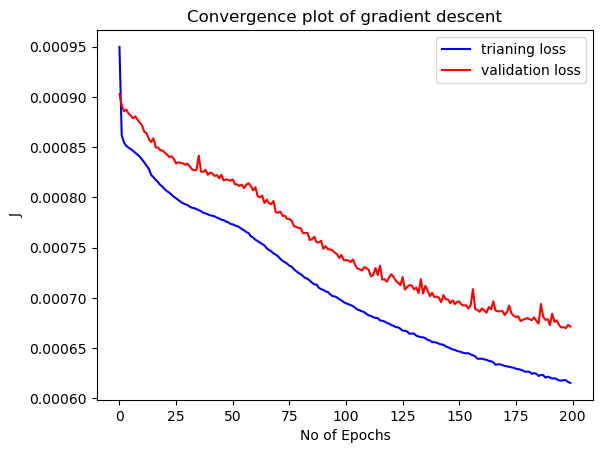

In [29]:
from matplotlib import pyplot as plt
plt.plot(train_history, 'b',label="trianing loss")
plt.plot(val_history, 'r',label = "validation loss")
plt.title('Convergence plot of gradient descent')
plt.xlabel('No of Epochs')
plt.ylabel('J')
plt.legend()
plt.show()

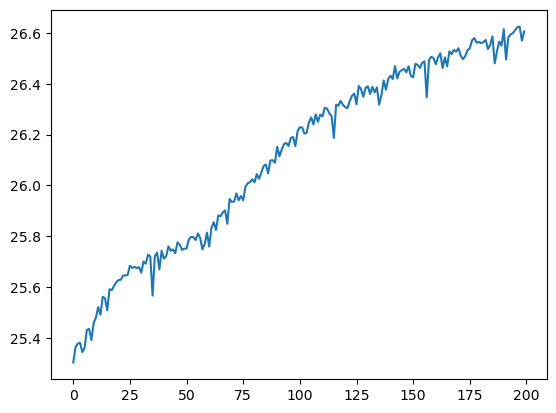

In [30]:

for i in range (len(psnrs)):
    psnrs[i] = psnrs[i].cpu()
plt.plot(psnrs)

In [31]:

np_psnrs = np.array(psnrs)
np_train_history = np.array(train_history)
np_val_history = np.array(val_history)


In [32]:
np.save('psnrs2.npy', np_psnrs)
np.save('val_history2.npy',np_val_history)
np.save('train_history2.npy',np_train_history)


In [9]:
import numpy as np

np_psnrs = np.load('Saves/Arrays/psnrs.npy')
np_train_history = np.load('Saves/Arrays/train_history.npy')
np_val_history = np.load('Saves/Arrays/val_history.npy')

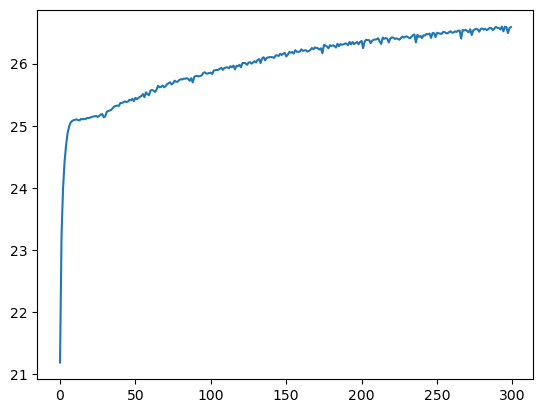

In [5]:
from matplotlib import pyplot as plt

plt.plot(np_psnrs)

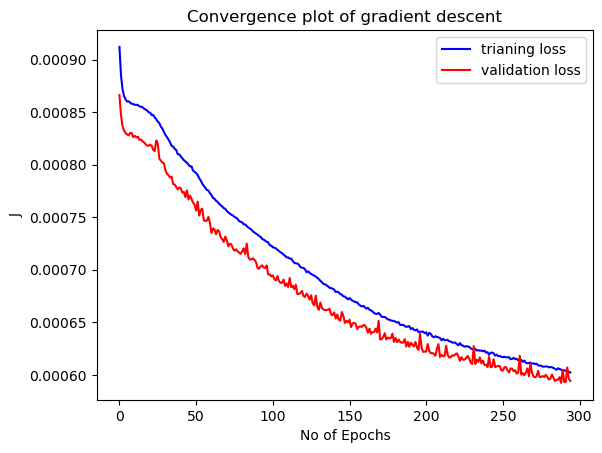

In [13]:
from matplotlib import pyplot as plt

plt.plot(np_train_history[5:], 'b',label="trianing loss")
plt.plot(np_val_history[5:], 'r',label = "validation loss")
plt.title('Convergence plot of gradient descent')
plt.xlabel('No of Epochs')
plt.ylabel('J')
plt.legend()
plt.show()

In [15]:
np_psnrs.argmax()
len(np_psnrs.tolist())

300

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [19]:
model = LPIENet(3, 3, [16, 32, 64], [32, 16])
model.load_state_dict(torch.load('Saves/Model_Saves/best.pth'))
model.to(device)
print(model)

LPIENet(
  (_encoders): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BaseBlock(
        (_conv0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (_dw_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
        (_conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (_conv2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (_conv3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): BaseBlock(
        (_conv0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (_dw_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
        (_conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (_conv2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (_conv3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (3): AttentionBlock(
        (_spatial_attention_conv): Conv2d(

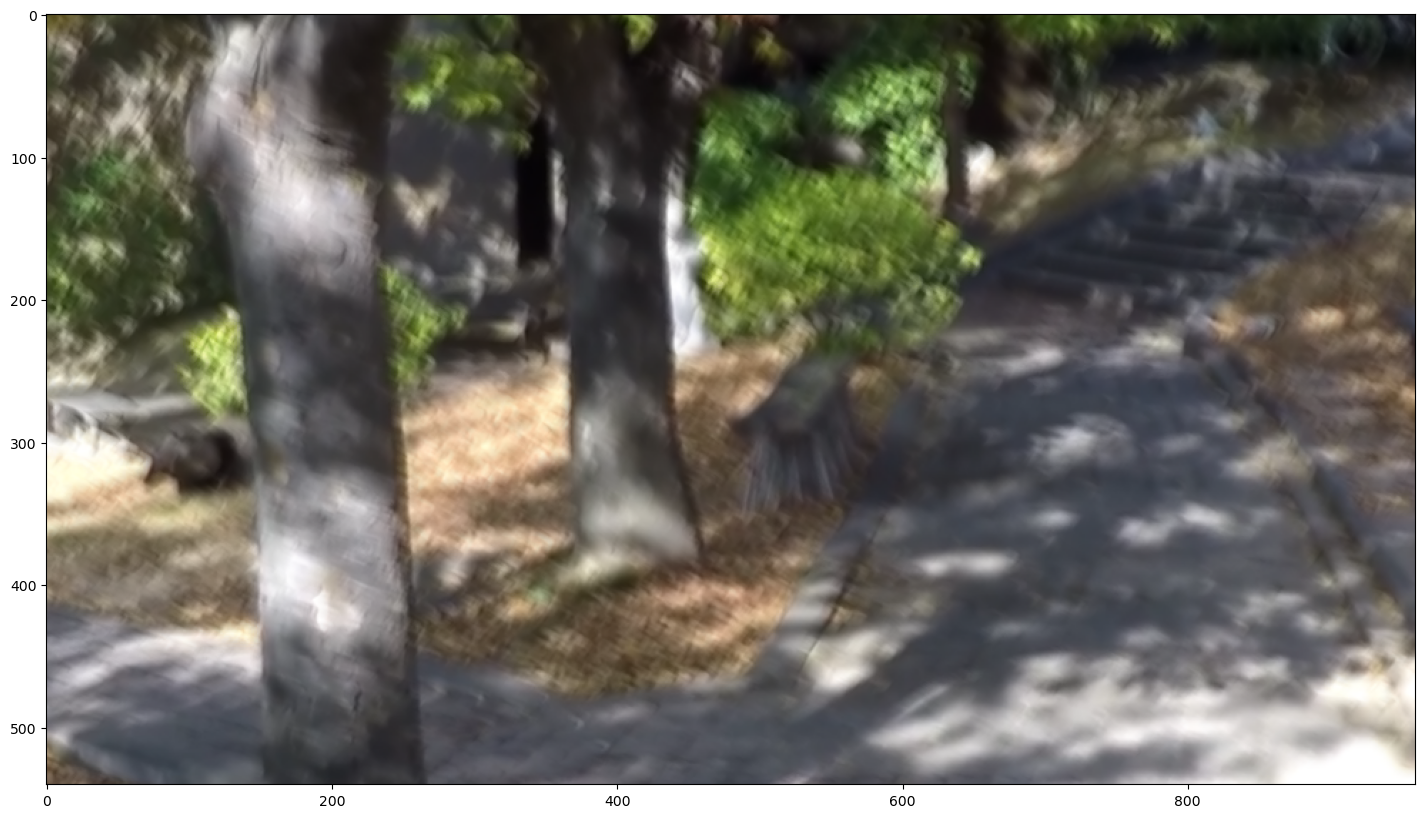

In [57]:
path = 'GoPro/test/GOPR0862_11_00/blur/000007.png'


from torchvision.io import read_image, ImageReadMode
from matplotlib import pyplot as plt
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((540,960)),
    transforms.ToTensor(),
])

img = read_image(path, mode=ImageReadMode.RGB)
img = transform(img)

plt.figure(figsize=(20,10))
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [58]:
batch = img.reshape(1, 3, 540, 960)

batch = batch.to(device)
result = model(batch)
result.shape

torch.Size([1, 3, 540, 960])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


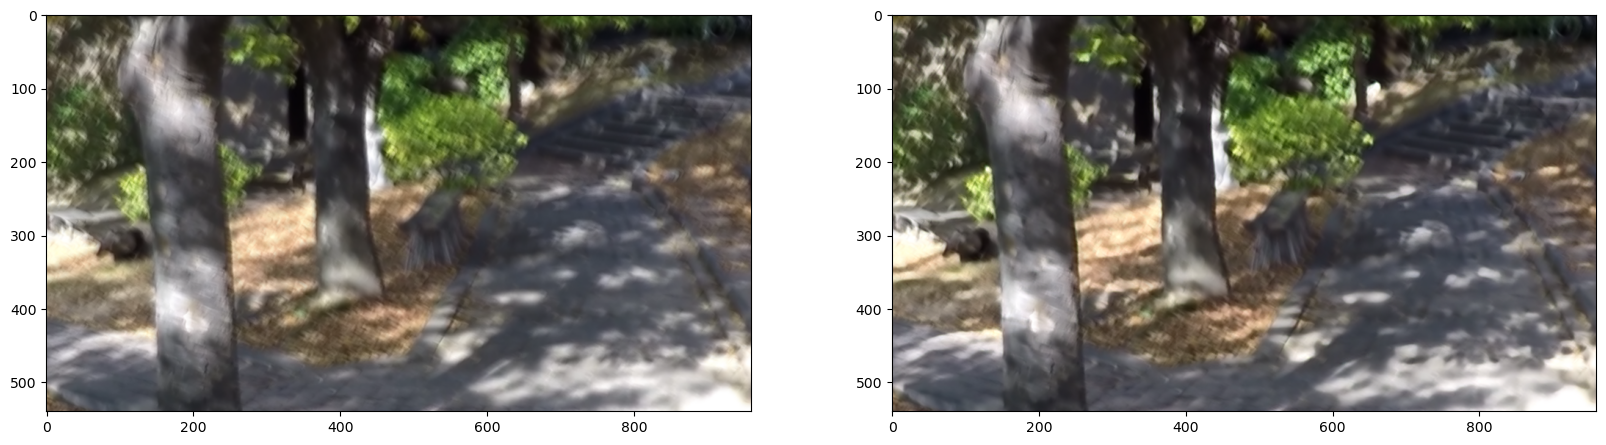

In [59]:
# result.reshape(3, 540, 960)


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(122)
plt.imshow(result[0].cpu().permute(1, 2, 0).detach().numpy())
plt.show()

In [69]:
def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1-img2)**2))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum/self.count

criteria = nn.MSELoss()

model.eval()
epoch_psnr = AverageMeter()
test_loss = 0
for data in test_loader:
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        preds = model(inputs)
        loss = criteria(preds, labels)
        test_loss += loss.item()
        preds = preds.clamp(0.0, 1.0)

    epoch_psnr.update(calc_psnr(preds, labels), len(inputs))

print('Test loss: {:.6f}'.format(test_loss/len(test_dataset)))
print('Test psnr: {:.2f}'.format(epoch_psnr.avg))

Test loss: 0.000596
Test psnr: 27.26
